# studying LMC & SMC

In [1]:
%matplotlib inline
# common functions used in the project of VR-R in GAC direction
import numpy as np
#import scipy.linalg as splin
import numpy.linalg as nl
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick',labelsize=20)
matplotlib.rc('ytick',labelsize=20)
font = {'size' : 20}
matplotlib.rc('font', **font)
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.special as special
import astropy.io.fits as fits
import math as m
import emcee
import corner
import pandas as pd
import csv
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import sys
sys.path.append('/Users/htian/Documents/GitHub/astroth/')
import CoordinateConversion as CC
import galpy.util.bovy_coords as gub
import sfdmap
import os

In [2]:
path = os.getcwd()
ppath = path+"/plots/"
fn_data = "GDR2_Mgiant_candidate_color2_b20_gmag10_20_rest_4000_EBV.fits"
#  dust map of schlegel
dmap=sfdmap.SFDMap('/Users/htian/Documents/GitHub/sfddata-master',scaling=1.0)   

In [3]:
dt = fits.open(path+"/"+fn_data)
data = dt[1].data
raGa,decGa = np.array(data["ra"]),np.array(data["dec"])
pmraGa,pmdecGa = np.array(data["pmra"]),np.array(data["pmdec"])
pmraGea,pmdecGea = np.array(data["pmra_error"]),np.array(data["pmdec_error"])
MagGa = np.array(data["phot_g_mean_mag"])
BPRPGa = np.array(data["bp_rp"])
lGa,bGa = np.array(data["l"]),np.array(data["b"])
S_IDa = data["source_id_1"]
AENa = data["astrometric_excess_noise"]
BEFa = data["phot_bp_rp_excess_factor"] 
EBVa = data["EBV"]
rvGa,rveGa = data["radial_velocity"],data["radial_velocity_error"]
ind = (AENa<0.25) & (BEFa<1.5) & (EBVa<0.8)
raG,decG = raGa[ind],decGa[ind]
pmraG,pmdecG = pmraGa[ind],pmdecGa[ind]
pmraGe,pmdecGe = pmraGea[ind], pmdecGea[ind]
MagG,BPRPG = MagGa[ind],BPRPGa[ind]
lG,bG = lGa[ind],bGa[ind]
S_ID = S_IDa[ind]
AEN = AENa[ind]
BEF = BEFa[ind]
EBV = EBVa[ind]
rv,rve = rvGa[ind],rveGa[ind]


In [4]:
ebv = dmap.ebv(raG,decG)   # ebv 
AmG = 2.35 * ebv           # extinction correction
# dynamical center
DC_LMC = [78.77, -69.01]    # coordinates of the LMC (ra, dec)  from AMINA_GC 1804.09381
DC_SMC = [16.26, -72.42]    # coordinates of the LMC (ra, dec)  from AMINA_GC 1804.09381
# photometric center
PC_LMC = [81.28, -69.78]    # coordinates of the LMC (ra, dec)  from AMINA_GC 1804.09381
PC_SMC = [12.80,-73.15]    # coordinates of the LMC (ra, dec)  from AMINA_GC 1804.09381


pmra_LMC, pmdec_LMC = 1.850,0.234     # PM of LMC  from AMINA_GC 1804.09381, errors are 0.030 0.030
pmra_SMC, pmdec_SMC = 0.797,-1.220    # PM of SMC  from AMINA_GC 1804.09381, errors are 0.030 0.030


D2LMC = np.sqrt((raG-PC_LMC[0])**2*np.cos(PC_LMC[1]*m.pi/180)**2 + (decG-PC_LMC[1])**2)
D2SMC = np.sqrt((raG-PC_SMC[0])**2*np.cos(PC_SMC[1]*m.pi/180)**2 + (decG-PC_SMC[1])**2)
R_LMC, R_SMC = 8.5,5
xp = np.cos(decG*m.pi/180)*np.sin((raG-DC_LMC[0])*m.pi/180)*180/m.pi
yp = 180/m.pi*(np.sin(decG*m.pi/180)*np.cos(DC_LMC[1]*m.pi/180)-\
     np.cos(decG*m.pi/180)*np.sin(DC_LMC[1]*m.pi/180)*np.cos((raG-DC_LMC[0])*m.pi/180))
Rp = np.sqrt(xp**2+yp**2)
pmx = (pmraG-pmra_LMC)*np.cos((raG-DC_LMC[0])*m.pi/180) - \
      (pmdecG-pmdec_LMC)*np.sin(decG*m.pi/180)*np.sin((raG-DC_LMC[0])*m.pi/180)
pmy = (pmraG-pmra_LMC)*np.sin(DC_LMC[1]*m.pi/180)*np.sin((raG-DC_LMC[0])*m.pi/180) + \
      (pmdecG-pmdec_LMC)*(np.cos(decG*m.pi/180)*np.cos(DC_LMC[1]*m.pi/180) + 
             np.sin(decG*m.pi/180)*np.sin(DC_LMC[1]*m.pi/180)*np.cos(raG-DC_LMC[0])*m.pi/180)

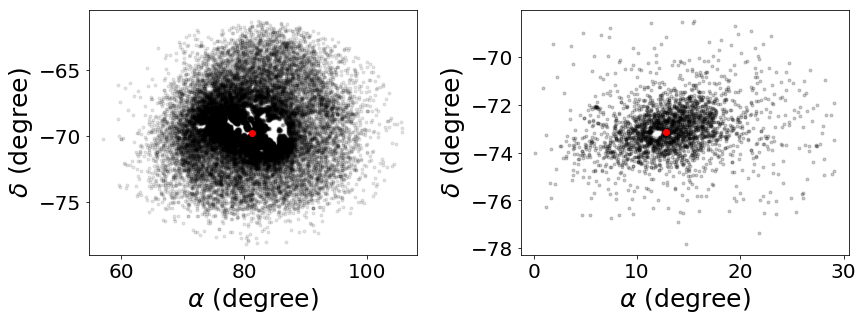

(19, 11)

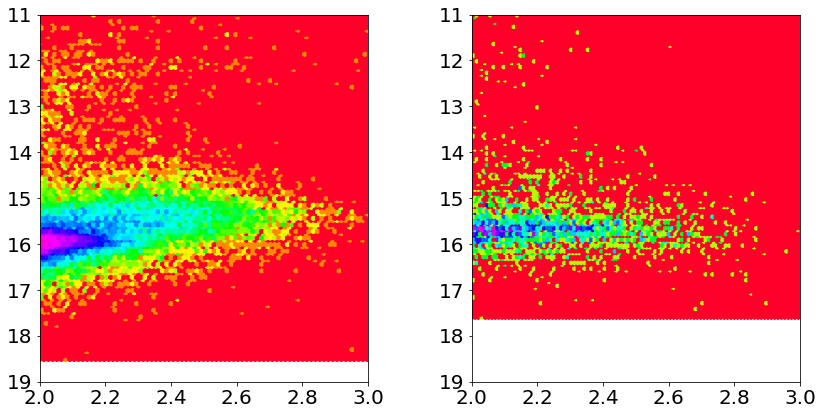

In [5]:
ind_LMC = D2LMC<R_LMC
ind_SMC = D2SMC<R_SMC

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_axes([0.1,0.2,0.38,0.85])
ax2 = fig.add_axes([0.6,0.2,0.38,0.85])
ax1.plot(raG[ind_LMC],decG[ind_LMC],'k.',alpha=0.1)
ax1.plot(PC_LMC[0],PC_LMC[1],'ro')
ax1.set_xlabel("$\\alpha$ (degree)",fontsize=25)
ax1.set_ylabel("$\\delta$ (degree)",fontsize=25)

ax2.plot(raG[ind_SMC],decG[ind_SMC],'k.',alpha=0.2)
ax2.plot(PC_SMC[0],PC_SMC[1],'ro')
ax2.set_xlabel("$\\alpha$ (degree)",fontsize=25)
ax2.set_ylabel("$\\delta$ (degree)",fontsize=25)
plt.show()

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0.1,0.2,0.38,0.85])
ax2 = fig.add_axes([0.6,0.2,0.38,0.85])
ax1.hexbin(BPRPG[ind_LMC],MagG[ind_LMC],bins="log",cmap="gist_rainbow")
ax1.set_xlim([2.0,3])
ax1.set_ylim([19,11])
ax2.hexbin(BPRPG[ind_SMC],MagG[ind_SMC],bins="log",cmap="gist_rainbow")
ax2.set_xlim([2.0,3])
ax2.set_ylim([19,11])

[14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18. ]
[2. 3.]


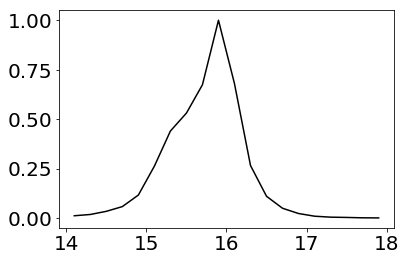

In [6]:
bins_BPRP = np.linspace(2,3,2)
bins_MAGG = np.linspace(14,18,21)
print(bins_MAGG)
half_BPRP = (bins_BPRP[1]-bins_BPRP[0]) * 0.5
half_MAGG = (bins_MAGG[1]-bins_MAGG[0]) * 0.5
print(bins_BPRP)
for i in range(0,1):
    min_m = bins_BPRP[i]
    max_m = bins_BPRP[i+1]
    indC = (BPRPG[ind_LMC]>min_m) & (BPRPG[ind_LMC]<=max_m)
    hy,hx = np.histogram(MagG[ind_LMC][indC],bins = bins_MAGG)
    plt.plot(hx[:-1]+half_MAGG,hy/np.max(hy),'k-')
#     plt.text(14)
    plt.show()

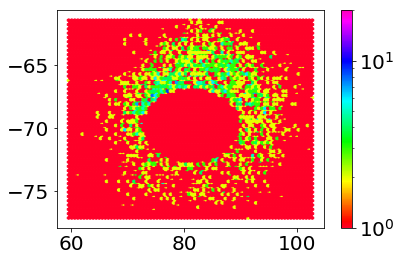

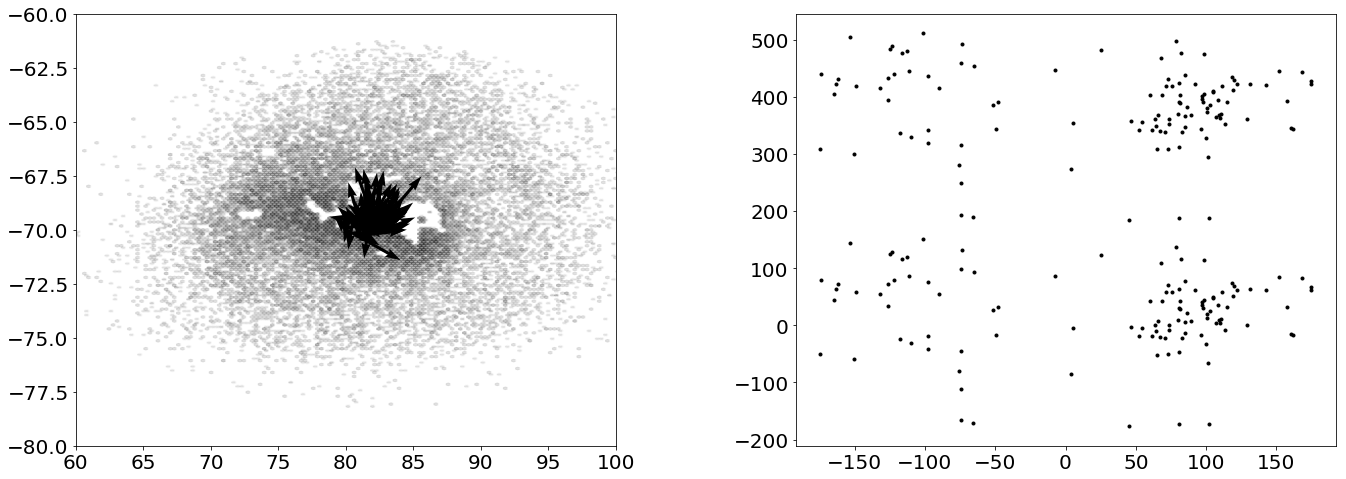

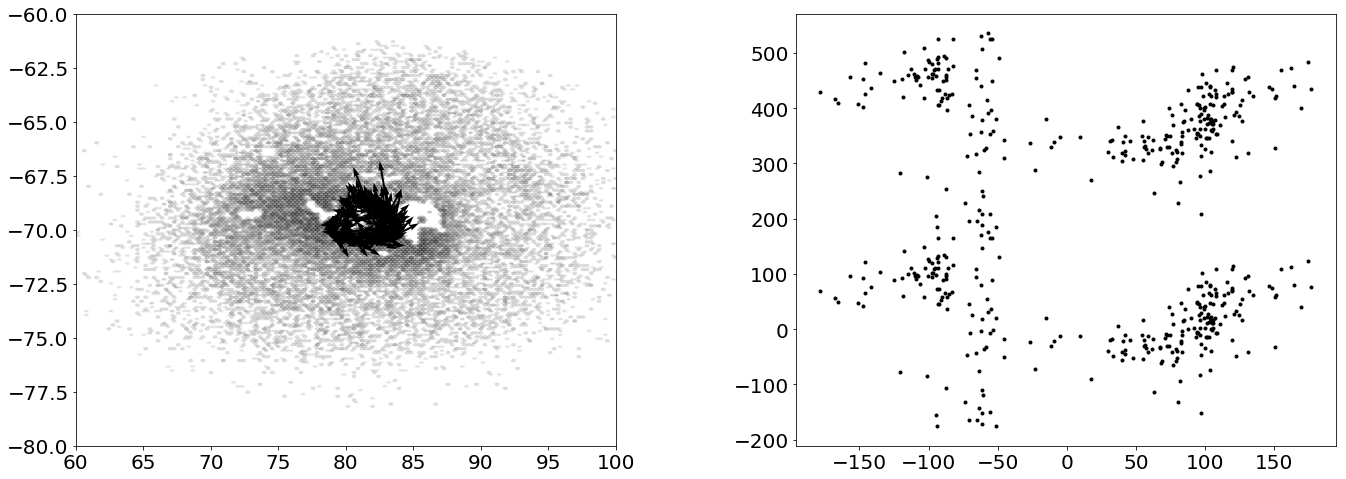

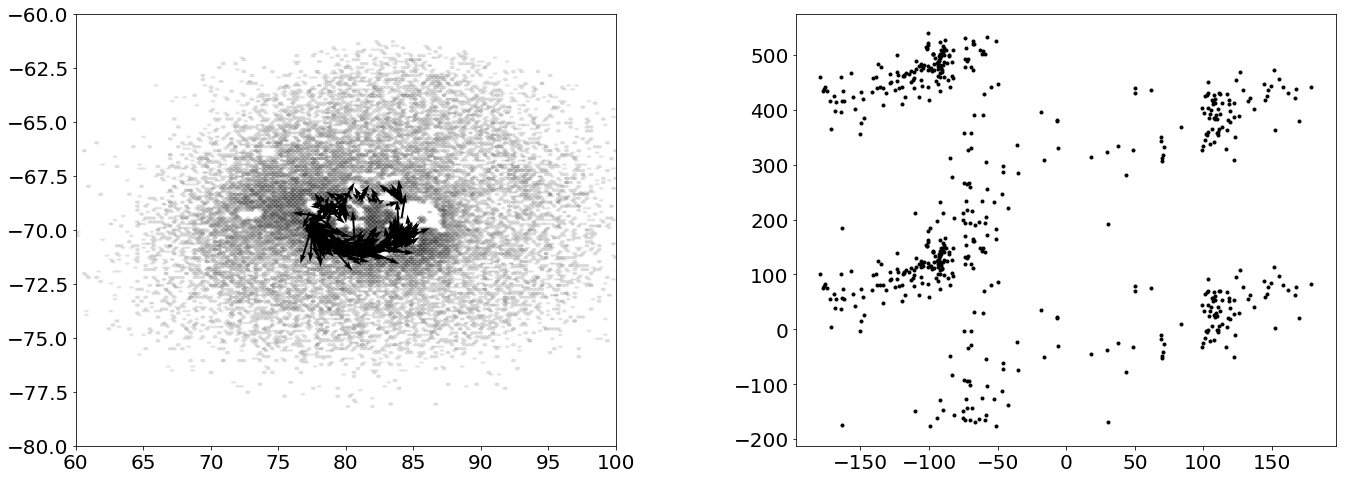

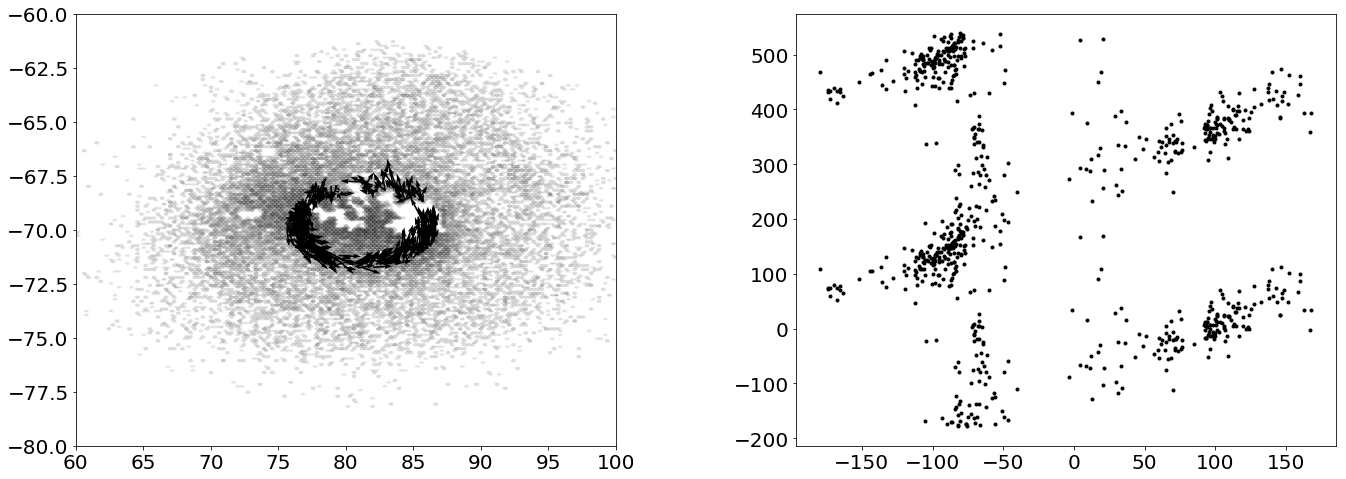

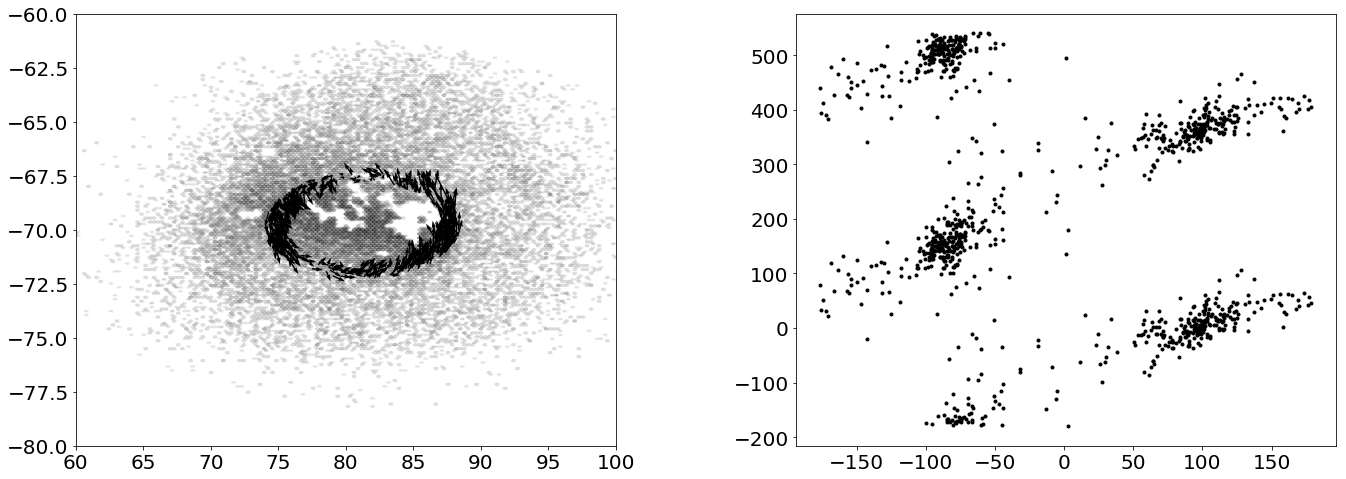

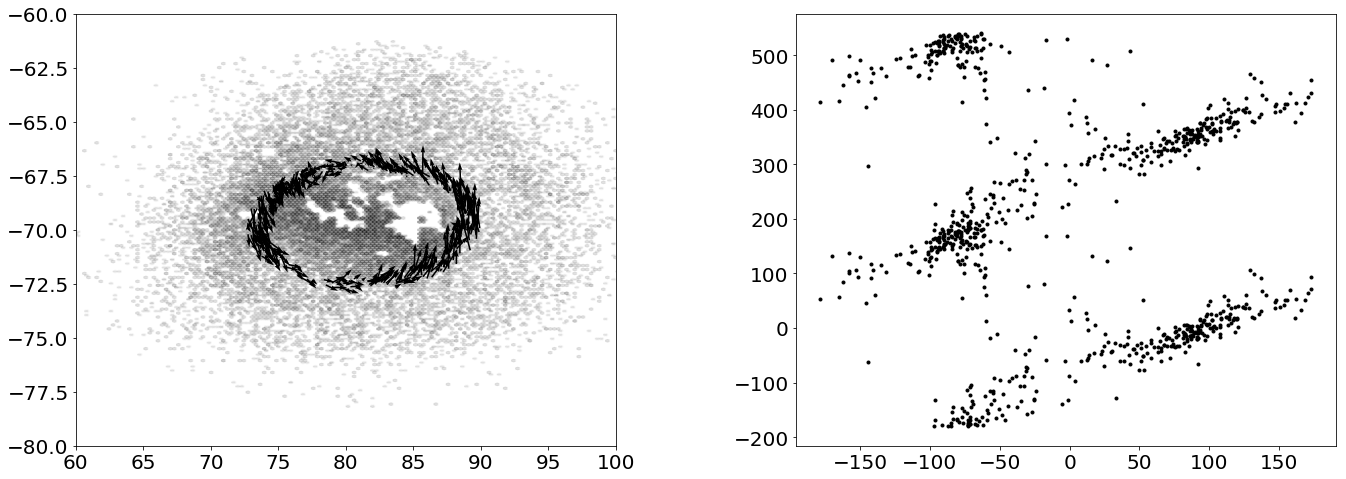

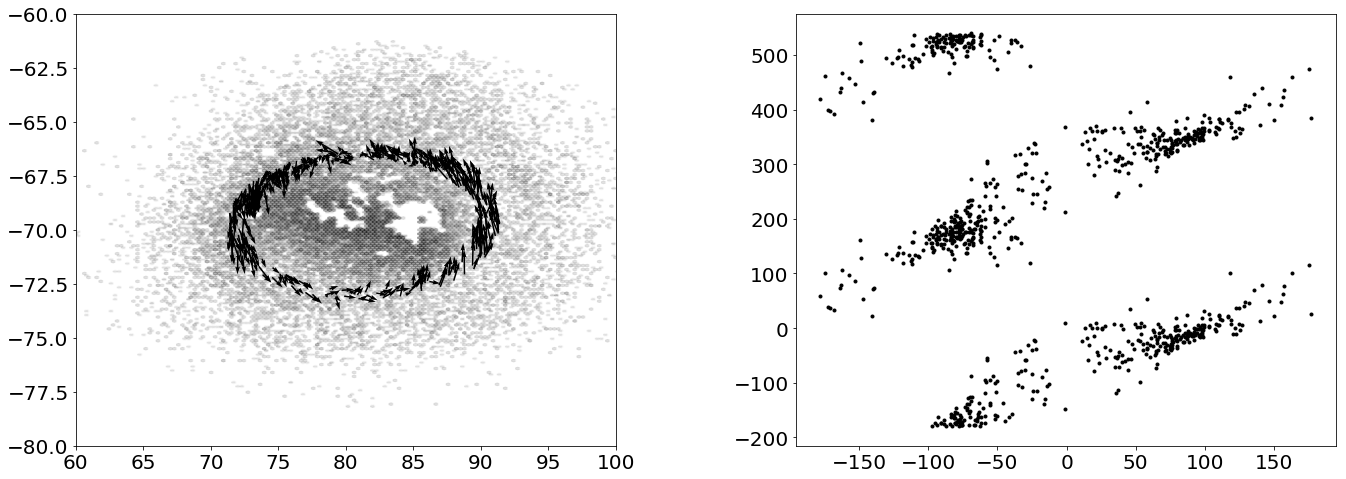

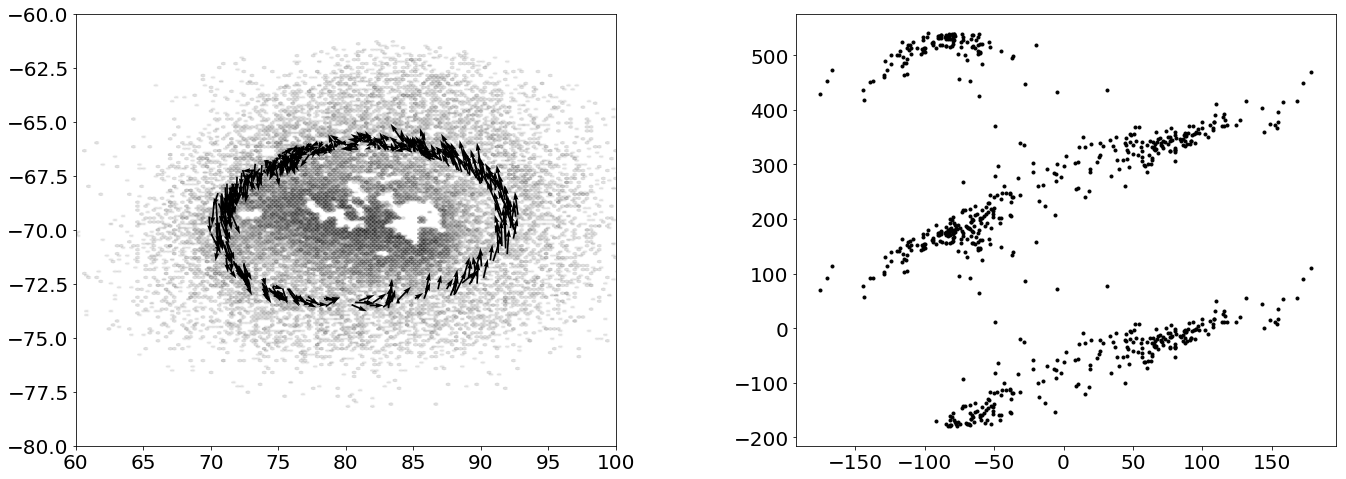

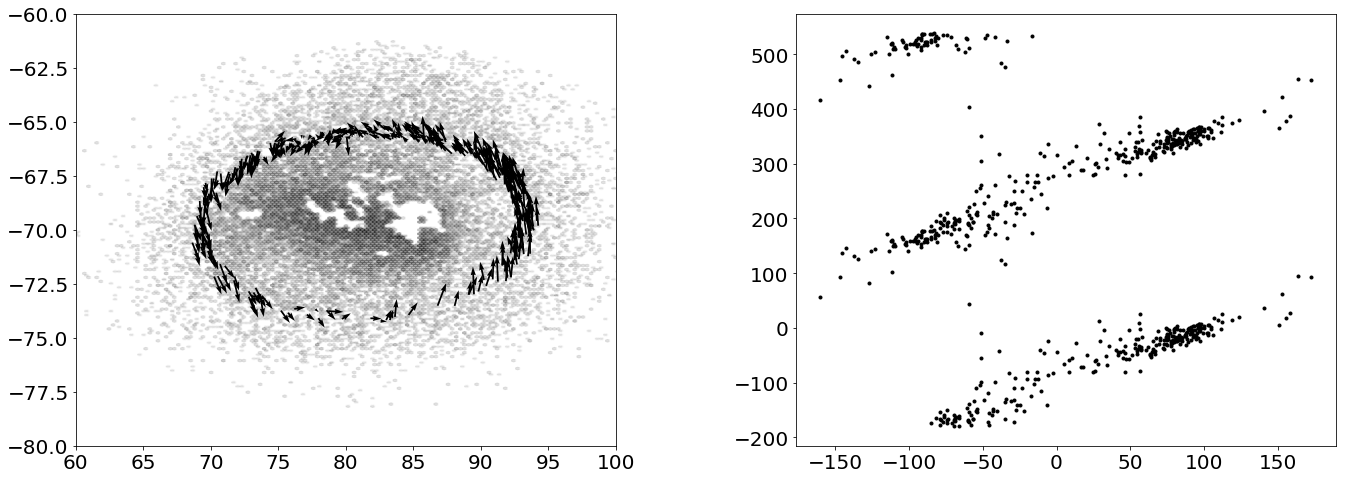

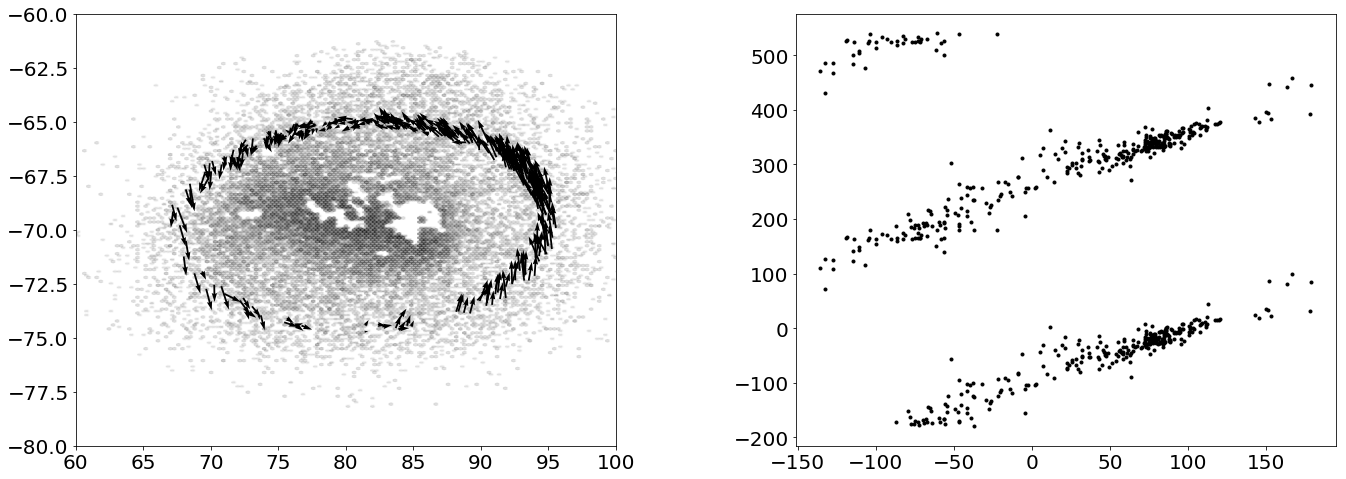

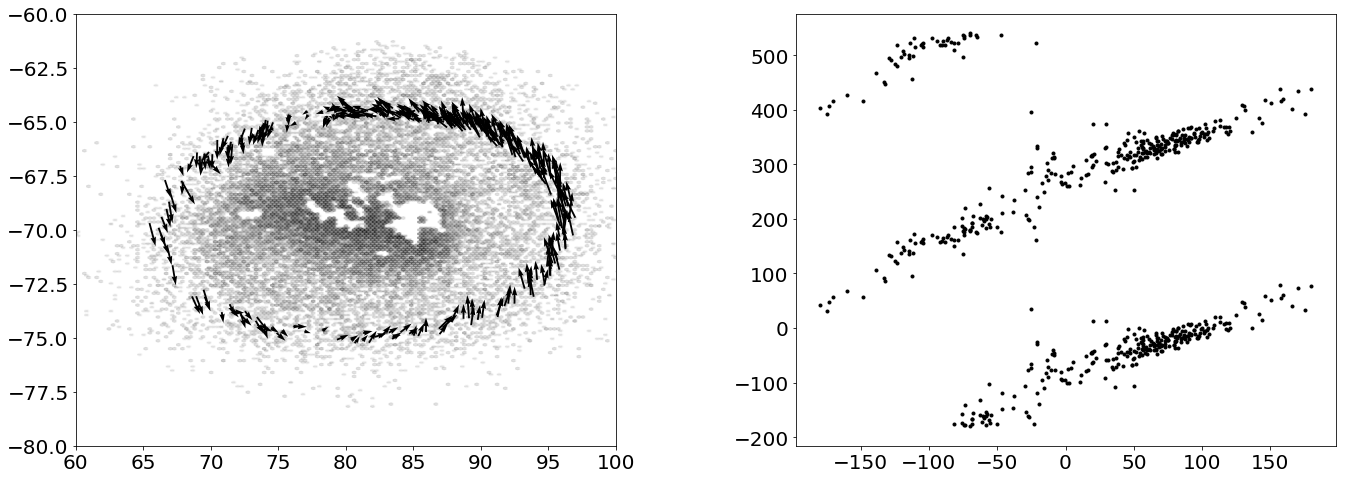

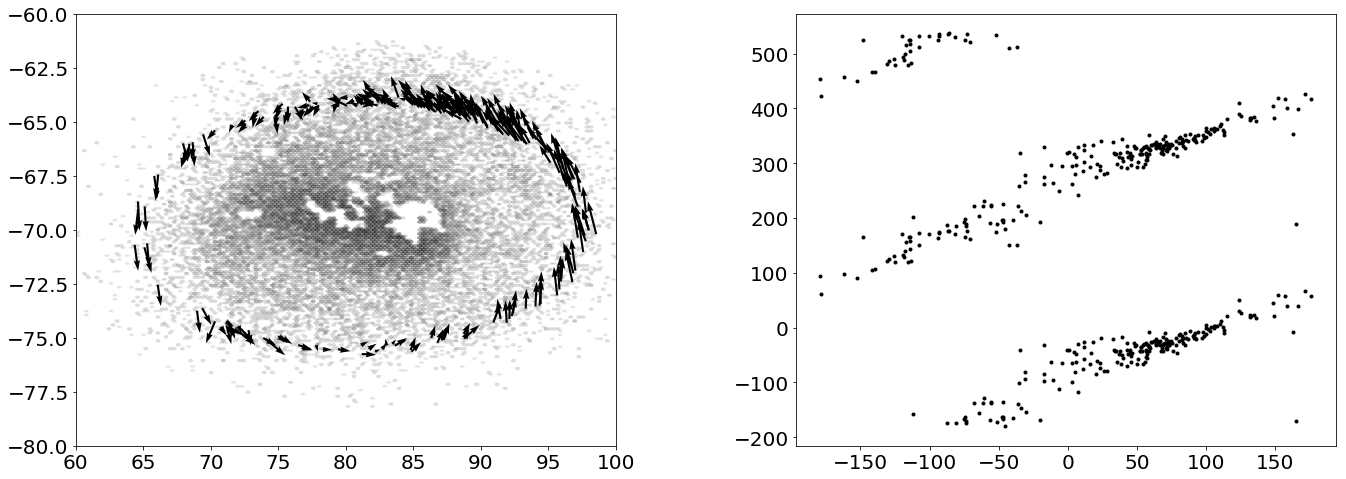

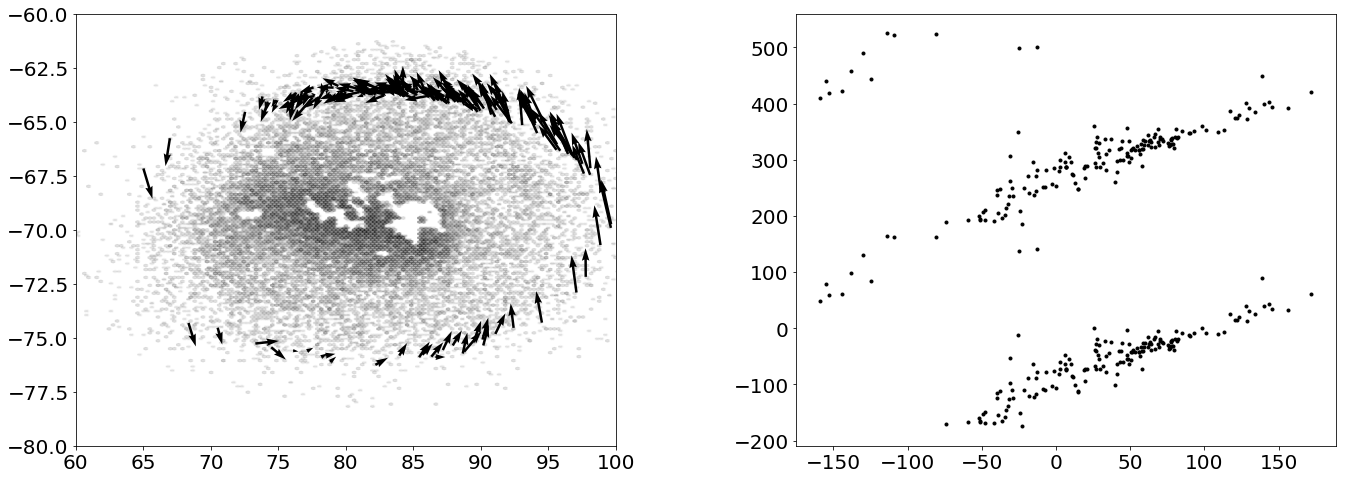

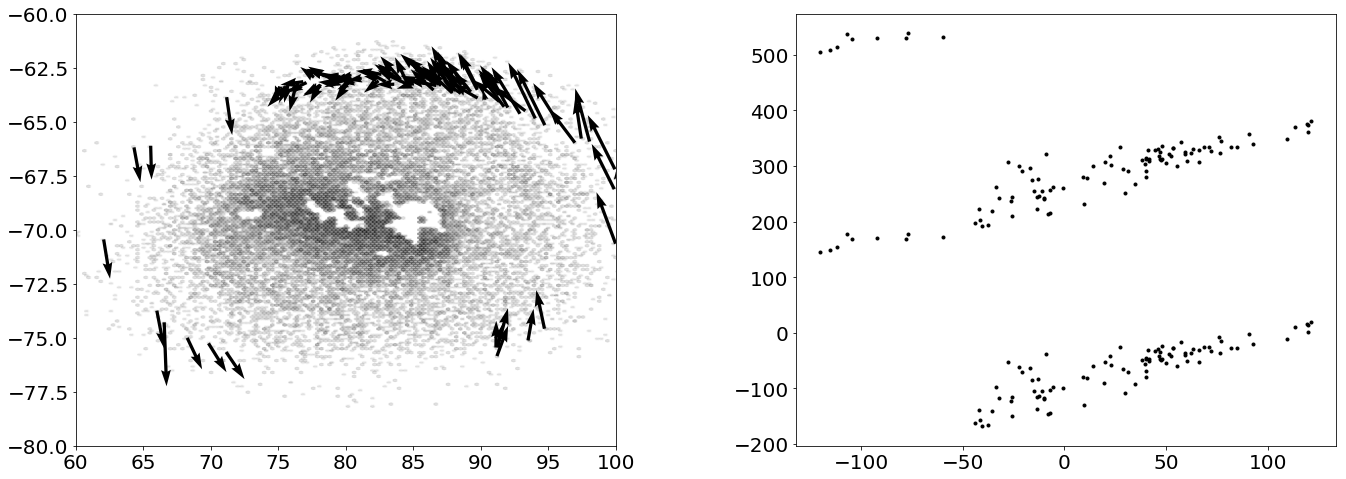

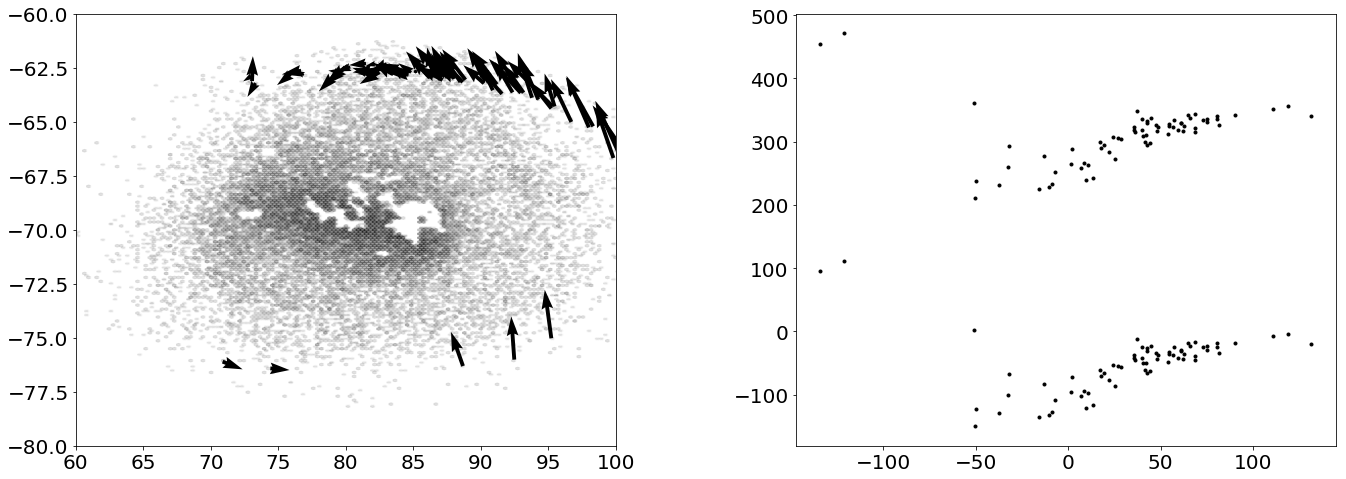

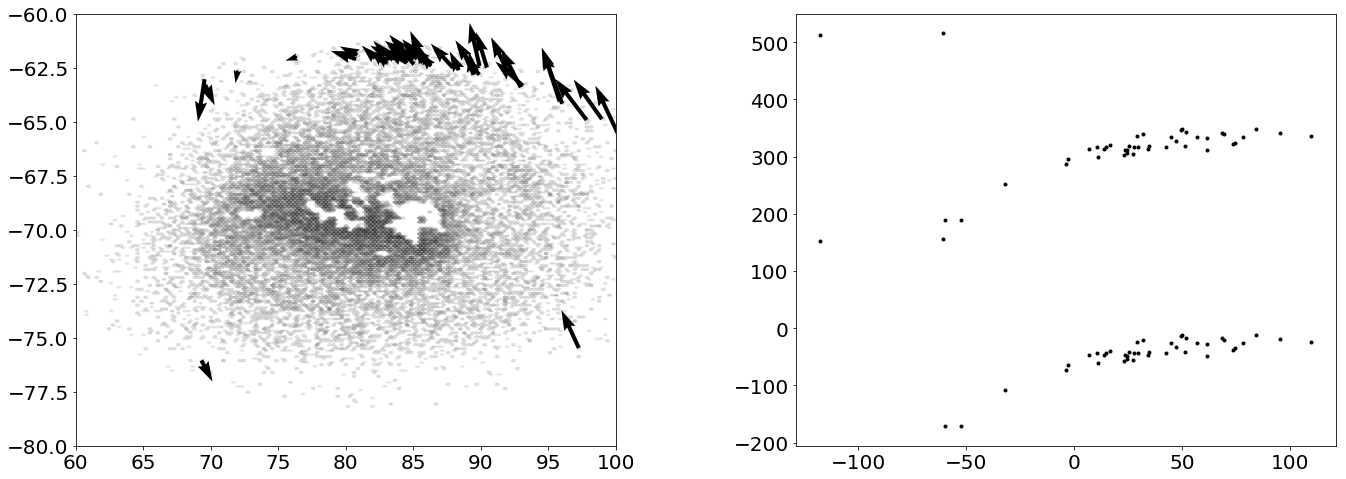

3.1288306063264684


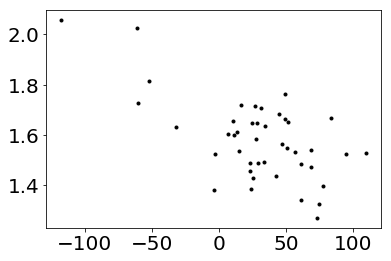

In [7]:
DD2LMC = np.sqrt((raG-PC_LMC[0])**2 + (decG-PC_LMC[1])**2)
theta_radecL = np.arctan2(raG-PC_LMC[0],decG-PC_LMC[1])*180/m.pi
theta_pmL = np.arctan2(pmraG-pmra_LMC,pmdecG-pmdec_LMC)*180/m.pi
ind = (BPRPG[ind_LMC]>2.2) & (MagG[ind_LMC]>14.5) & (MagG[ind_LMC]<15.5) & (D2LMC[ind_LMC]>3)
plt.hexbin(raG[ind_LMC][ind],decG[ind_LMC][ind],bins="log",cmap="gist_rainbow",gridsize=80,vmin=1,vmax=20)
plt.colorbar()
plt.show()
bins_r = np.linspace(0,8,17)
for i in range(0,16):
    min_r,max_r = bins_r[i],bins_r[i+1]
    inddd = (BPRPG[ind_LMC]>2.2) & (MagG[ind_LMC]>14.5) & (MagG[ind_LMC]<15.5) & \
            (D2LMC[ind_LMC]>min_r) & (D2LMC[ind_LMC]<max_r)
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_axes([0.1,0.2,0.375,0.75])
    ax2 = fig.add_axes([0.6,0.2,0.375,0.75])
    ax1.hexbin(raG[ind_LMC],decG[ind_LMC],bins="log",gridsize=160,cmap="binary",alpha=0.5)
    ax1.quiver(raG[ind_LMC][inddd],decG[ind_LMC][inddd],
              pmraG[ind_LMC][inddd]-pmra_LMC,pmdecG[ind_LMC][inddd]-pmdec_LMC,alpha=1)
    ax2.plot(theta_radecL[ind_LMC][inddd],theta_pmL[ind_LMC][inddd],"k.")
    ax2.plot(theta_radecL[ind_LMC][inddd],theta_pmL[ind_LMC][inddd]+360,"k.")
    ax1.set_xlim(60,100)
    ax1.set_ylim(-80,-60)
    plt.show()
print(np.min(np.abs(np.arctan2(pmraG[ind_LMC][ind]-pmra_LMC,decG[ind_LMC][ind]-pmdec_LMC))))
plt.plot(theta_radecL[ind_LMC][inddd],pmraG[ind_LMC][inddd],'k.')

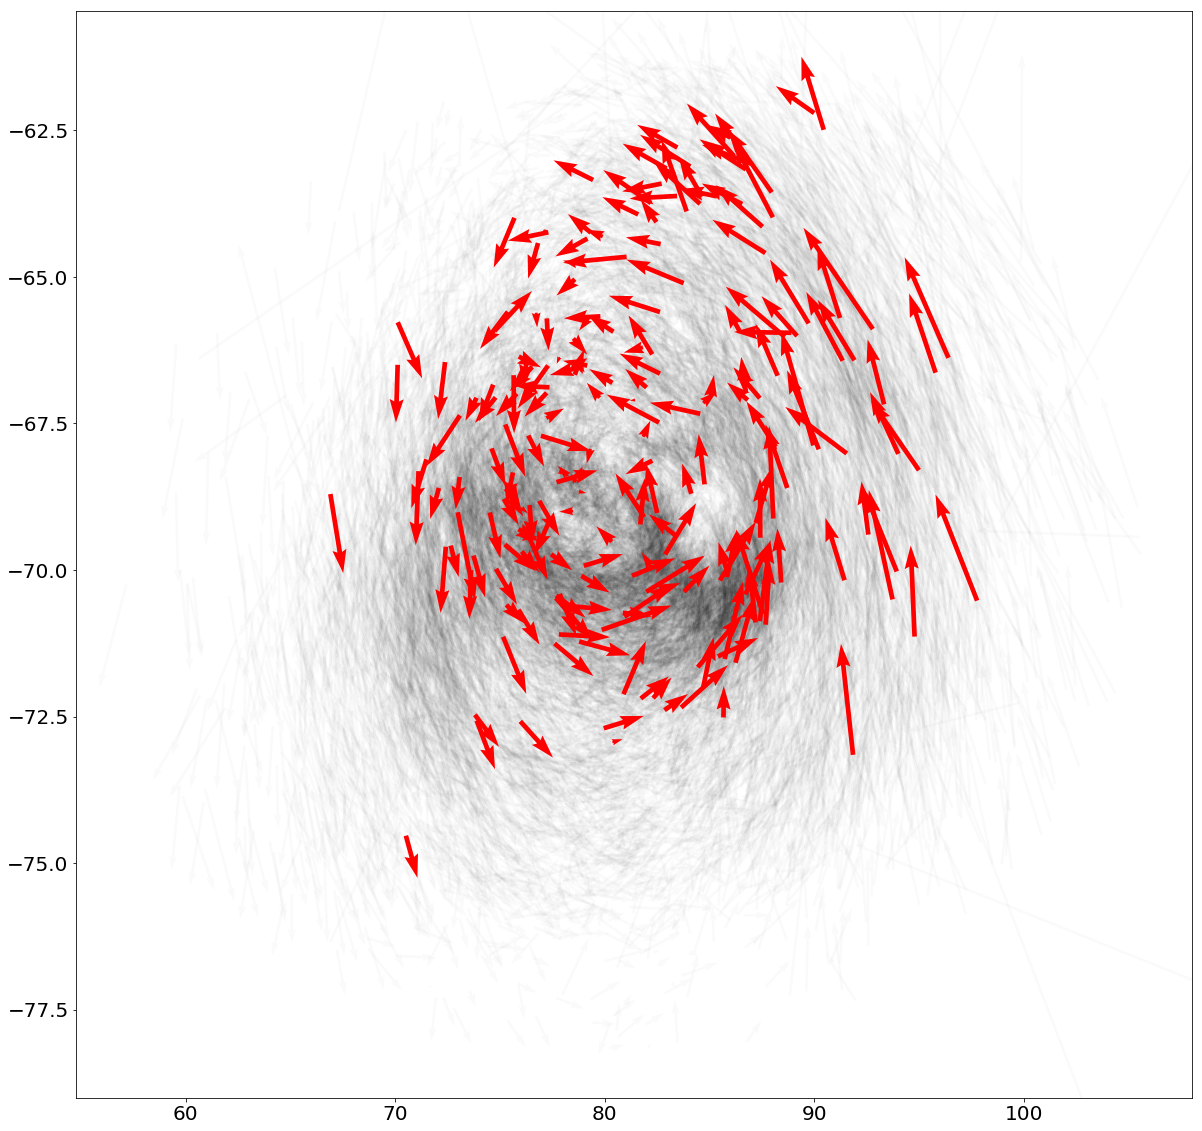

In [8]:
# fig = plt.figure(figsize=(20,20))
# indd = (BPRPG[ind_LMC]>2.5) & (MagG[ind_LMC]>14) & (MagG[ind_LMC]<15.) & (D2LMC[ind_LMC]<8.5)
# plt.quiver(raG[ind_LMC][indd],decG[ind_LMC][indd],
#               pmraG[ind_LMC][indd]-pmra_LMC,pmdecG[ind_LMC][indd]-pmdec_LMC,alpha=1,scale=10)
# plt.axis([85,88,-75,-60])
# plt.show()

fig = plt.figure(figsize=(20,20))
indd = (BPRPG[ind_LMC]>2.5) & (MagG[ind_LMC]>14) & (MagG[ind_LMC]<15.) & (D2LMC[ind_LMC]<8.5)
# plt.plot(raG[ind_LMC],decG[ind_LMC],'k.',alpha=0.1)
plt.quiver(raG[ind_LMC],decG[ind_LMC],
              pmraG[ind_LMC]-pmra_LMC,pmdecG[ind_LMC]-pmdec_LMC,scale=10,alpha=0.02)
plt.quiver(raG[ind_LMC][indd],decG[ind_LMC][indd],
              pmraG[ind_LMC][indd]-pmra_LMC,pmdecG[ind_LMC][indd]-pmdec_LMC,alpha=1,scale=10,color='r')
# plt.axis([75,80,-80,-60])

plt.show()
# plt.axis([70,75,-72,-68])

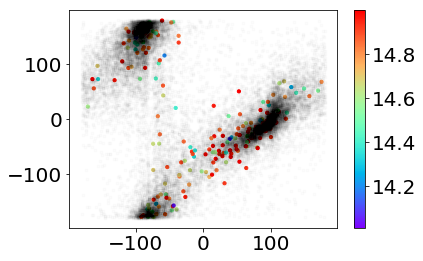

In [9]:
plt.scatter(theta_radecL[ind_LMC][indd],theta_pmL[ind_LMC][indd],s=10,c=MagG[ind_LMC][indd],cmap="rainbow")
plt.plot(theta_radecL[ind_LMC],theta_pmL[ind_LMC],"k.",alpha=0.01)
plt.colorbar()

25269


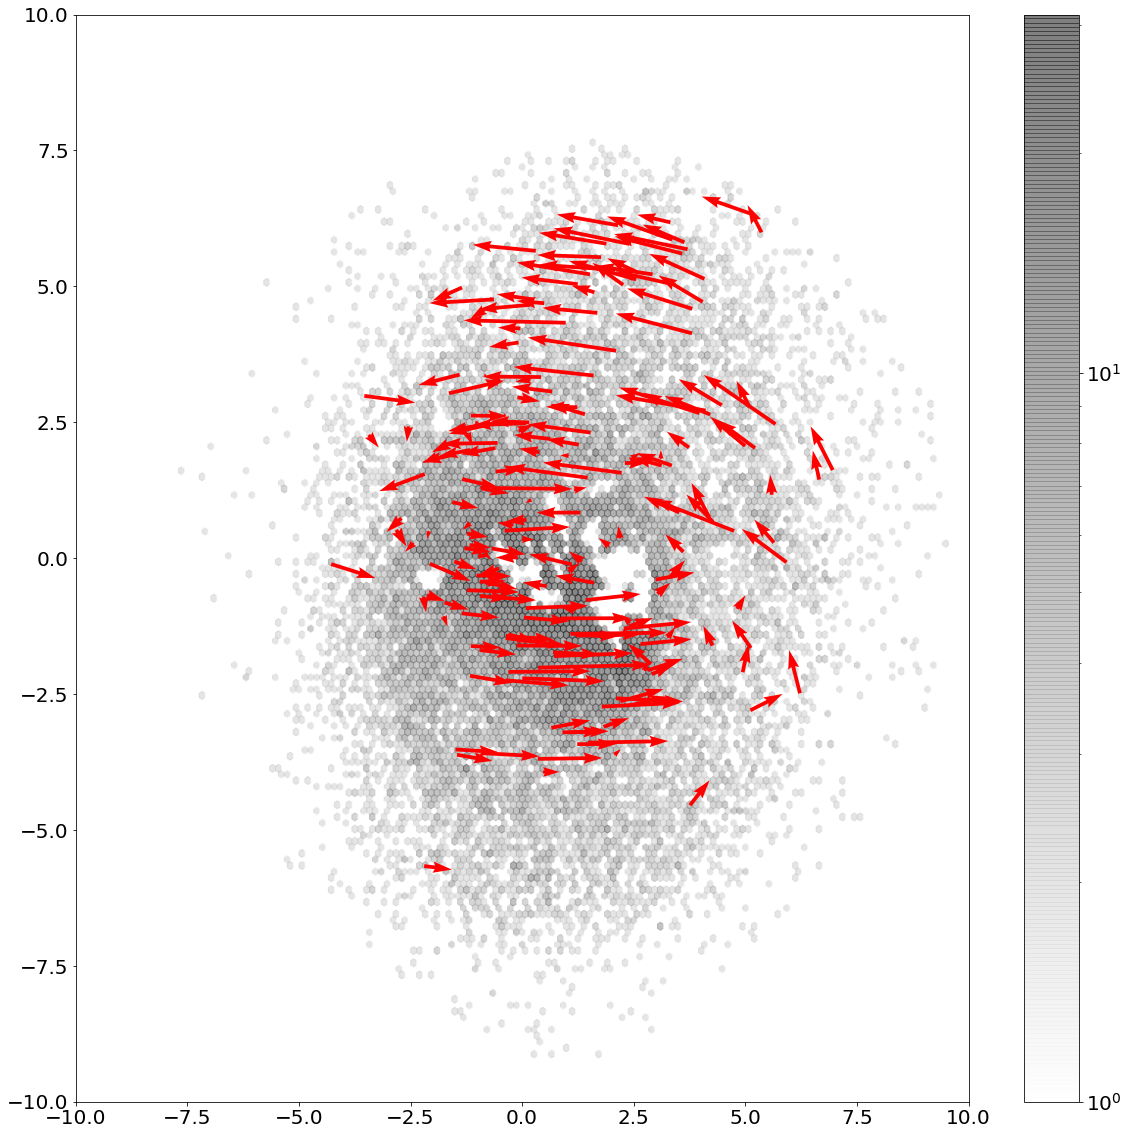

In [12]:
fig = plt.figure(figsize=(20,20))
plt.hexbin(xp[ind_LMC],yp[ind_LMC],bins="log",gridsize=130,cmap="binary",alpha=0.5)
plt.colorbar()
# plt.quiver(xp[ind_LMC],yp[ind_LMC],pmx[ind_LMC],pmy[ind_LMC],scale=10,color="b",alpha=0.7)
plt.quiver(xp[ind_LMC][indd],yp[ind_LMC][indd],pmx[ind_LMC][indd],pmy[ind_LMC][indd],scale=5,color="r")
print(len(xp[ind_LMC]))
plt.axis([-10,10,-10,10])
plt.savefig("/Users/htian/Desktop/LMC.pdf")
plt.show()

[0, 0.2, 0, 26]

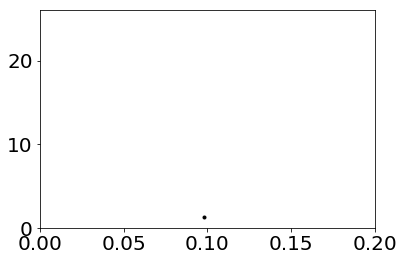

In [11]:
plt.plot(Rp[ind_LMC][indd][np.abs(Rp[ind_LMC][indd])>0.05],\
         np.sqrt(pmx**2+pmy**2)[ind_LMC][indd][np.abs(Rp[ind_LMC][indd])>0.05]/Rp[ind_LMC][indd][np.abs(Rp[ind_LMC][indd])>0.05],"k.",alpha=1)
plt.axis([0,0.2,0,26])